In [123]:
import pandas as pd
import numpy as np
from plotnine import *

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [124]:
data = pd.read_csv("https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1")

In [125]:
data.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

In [126]:
#creating the target and the predictor variables
X= data[["age", "chol"]]
y= data['diagnosis']

In [127]:
# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [128]:
#Model Specification
logreg = LogisticRegression()

#pipeline Creation
model_pipeline = Pipeline(
    [
    ("logisticreg_classification", logreg)]
  )

#predictions for the test data
model = model_pipeline.fit(X, y)

model.predict(X)

# Extract coefficientas
model_coef = model_pipeline.named_steps['logisticreg_classification'].coef_ # Extracting the Coefficients
model_coef

array([[0.04686331, 0.00180124]])

In [129]:
model_intercept = model_pipeline.named_steps['logisticreg_classification'].intercept_ # Extracting the Coefficients
model_intercept

array([-3.24011226])

### For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [130]:
# Given values
age = 55
coefficient_age = model_coef[0][0]
coefficient_chol = model_coef[0][1]
intercept = -(model_intercept[0])

# rearrange zi = W1 * x1 + W2 * x2 + C when zi = 0 and age is 55 to find cuttoff for cholesterol.
constant_term = intercept - coefficient_age * age

# Calculate chol
chol = constant_term / coefficient_chol

print(f"For a 55 year old, their cholesterol would need to be {chol:f} for the doctors to predict heart disease.")

For a 55 year old, their cholesterol would need to be 367.874890 for the doctors to predict heart disease.


### How high for the doctors to estimate a 90% chance that heart disease is present?

In [131]:
confidence = .9

# zi = log(pi/1-pi) would be the equation to find the cuttof which is 0, so first find zi with 90%
zi = np.log(confidence/(1-confidence))

# Given values
age = 55
coefficient_age = model_coef[0][0]
coefficient_chol = model_coef[0][1]
intercept = -(model_intercept[0])

#rearrange z = mx + c to be zi at 90% and solve for cholesterol for a 55 year old. 
constant_term = zi - coefficient_age * age + intercept

# Calculate chol
chol90 = constant_term / coefficient_chol

print(f"For the doctors to estimate a 90% chance that heart disease is present their cholesterol would have to be {chol90:f}.")

For the doctors to estimate a 90% chance that heart disease is present their cholesterol would have to be 1587.715879.


## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

In [132]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [133]:
lda = LinearDiscriminantAnalysis()

In [134]:
# Model Specification
lda = LinearDiscriminantAnalysis()

#pipeline Creation
model_2_pipeline = Pipeline(
    [
    ("lda_classification", lda)]
  )

#predictions for the test data
model_2 = model_2_pipeline.fit(X, y)

model_2_preds = model_2.predict(X)

# Extract coefficientas
model_2_coef = model_2_pipeline.named_steps['lda_classification'].coef_ # Extracting the Coefficients
print(model_coef)
model_2_intercept = model_2_pipeline.named_steps['lda_classification'].intercept_ # Extracting the Coefficients
print(model_2_intercept)

[[0.04686331 0.00180124]]
[-3.21967766]


- this is maximizing the probability of future observations falling on the correct side of the line

- assumes normal distributions and goes from there

### For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [135]:
# Given values
age = 55
coefficient_age = model_2_coef[0][0]
coefficient_chol = model_2_coef[0][1]
intercept = -(model_2_intercept[0])

# rearrange zi = W1 * x1 + W2 * x2 + C when zi = 0 and age is 55 to find cuttoff for cholesterol.
constant_term = intercept - coefficient_age * age

# Calculate chol
chol = constant_term / coefficient_chol

print(f"For a 55 year old, their cholesterol would need to be {chol:f} for the doctors to predict heart disease.")

For a 55 year old, their cholesterol would need to be 368.235358 for the doctors to predict heart disease.


## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

In [136]:
from sklearn.svm import SVC

# Model Specification
svc = SVC(kernel='linear')  # You can specify different kernels based on your problem

# Pipeline Creation
model_3_pipeline = Pipeline([
    ("svc_classification", svc)
])

#tuning using grid Search
params = {'svc_classification__C': [.0001, .001, .01, .1, 1, 10]}

gscv = GridSearchCV(model_3_pipeline, params, cv = cv, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the K's from the results corresponding to the
lambdas = gscv_fitted.cv_results_['param_svc_classification__C']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"lambda": lambdas, "roc_auc": mean_test_scores}).sort_values(by='roc_auc', ascending=False)
model_scores.head()

,lambda,roc_auc
5,10,0.640288
1,0.001,0.632250
2,0.01,0.628714
0,0.0001,0.628209
3,0.1,0.619371


In [137]:
from sklearn.svm import SVC

# Model Specification
svc = SVC(kernel='linear', C=10)  # You can specify different kernels based on your problem

# Pipeline Creation
model_3_pipeline = Pipeline([
    ("svc_classification", svc)
])

# Fit the model
model_3 = model_3_pipeline.fit(X, y)

# Make predictions on the test data
model_3_preds = model_3.predict(X)

# Extract coefficients
model_3_coef = model_3_pipeline.named_steps['svc_classification'].coef_
model_3_intercept = model_3_pipeline.named_steps['svc_classification'].intercept_

print("Coefficients:", model_3_coef)
print("Intercept:", model_3_intercept)

Coefficients: [[0.06438016 0.00365796]]
Intercept: [-4.68484664]


### For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [138]:
# Given values
age = 55
coefficient_age = model_3_coef[0][0]
coefficient_chol = model_3_coef[0][1]
intercept = -(model_3_intercept[0])

# rearrange zi = W1 * x1 + W2 * x2 + C when zi = 0 and age is 55 to find cuttoff for cholesterol.
constant_term = intercept - coefficient_age * age

# Calculate chol
chol = constant_term / coefficient_chol

print(f"For a 55 year old, their cholesterol would need to be {chol:f} for the doctors to predict heart disease.")

For a 55 year old, their cholesterol would need to be 312.725386 for the doctors to predict heart disease.


## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

In [139]:
# Create a DataFrame for plotting
plot_data = pd.DataFrame({'age': X['age'], 'chol': X['chol'], 'diagnosis': y})

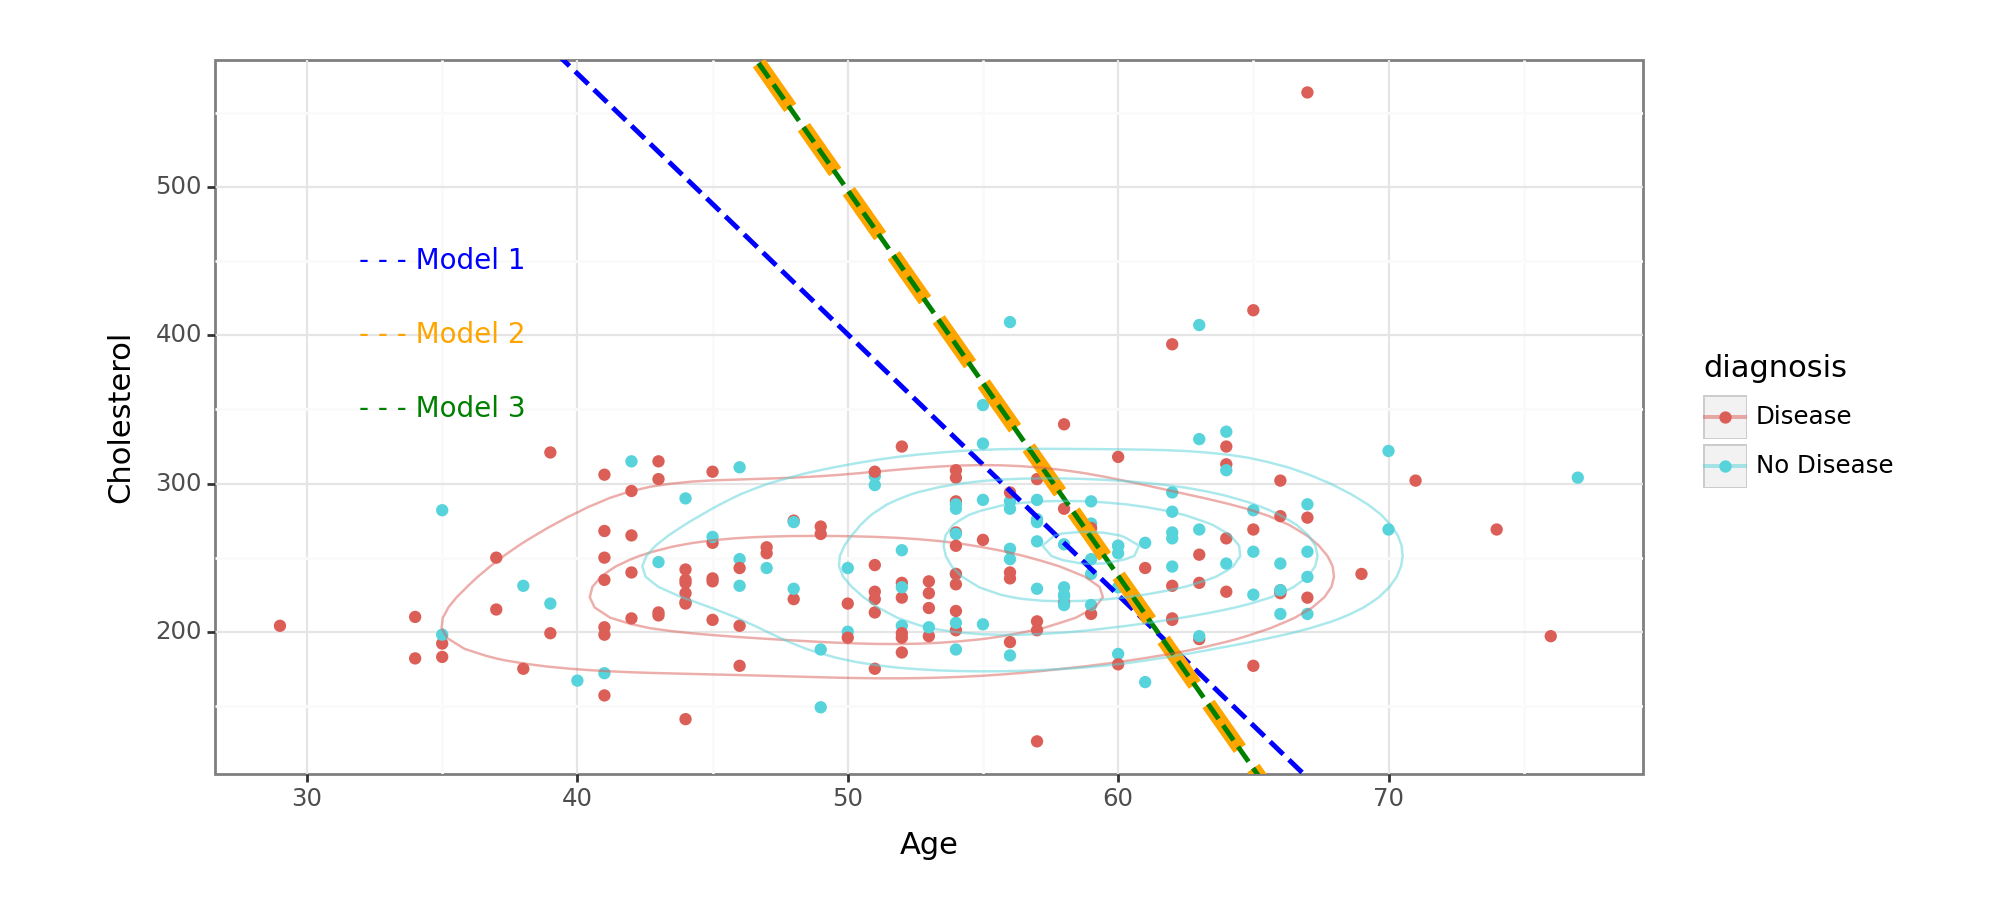

<Figure Size: (1000 x 450)>

In [140]:
# Plotting
(ggplot(plot_data, aes(x='age', y='chol', color='diagnosis'))
+ geom_point()
+ geom_abline(aes(intercept=-model_3_pipeline.named_steps['svc_classification'].intercept_[0] / model_3_pipeline.named_steps['svc_classification'].coef_[0][1],
             slope=-model_3_pipeline.named_steps['svc_classification'].coef_[0][0] / model_3_pipeline.named_steps['svc_classification'].coef_[0][1]),
             linetype='dashed', color='blue', show_legend=True, size=1) #line for svc
 
+ geom_abline(aes(intercept=-model_2_pipeline.named_steps['lda_classification'].intercept_[0] / model_2_pipeline.named_steps['lda_classification'].coef_[0][1],
             slope=-model_2_pipeline.named_steps['lda_classification'].coef_[0][0] / model_2_pipeline.named_steps['lda_classification'].coef_[0][1]),
             linetype='dashed', color='orange', show_legend=True, size=3) #line for lda
 
+ geom_abline(aes(intercept=-model_pipeline.named_steps['logisticreg_classification'].intercept_[0] / model_pipeline.named_steps['logisticreg_classification'].coef_[0][1],
             slope=-model_pipeline.named_steps['logisticreg_classification'].coef_[0][0] / model_pipeline.named_steps['logisticreg_classification'].coef_[0][1]),
             linetype='dashed', color='green', show_legend=True, size=1) #line for logreg

+ annotate("text", x=35, y=450, label='- - - Model 1', color='blue', size=10)  # Annotation for SVC
+ annotate("text", x=35, y=400, label='- - - Model 2', color='orange', size=10)  # Annotation for LDA
+ annotate("text", x=35, y=350, label='- - - Model 3', color='green', size=10)  # Annotation for Logistic Regression
     
+ scale_linetype_manual(values=['dashed', 'dashed', 'dashed'], labels=['SVC', 'LDA', 'Logistic Regression'])
+ geom_density_2d(aes(x='age', y='chol', fill='..level..'), data=plot_data, alpha=0.5)
+ theme_bw()
+ theme(aspect_ratio=.5, figure_size=(10, 4.5))
+ xlab("Age") + ylab("Cholesterol")
)